In [1]:
pip install tbats

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib as mp
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
import seaborn as sns
%matplotlib inline
mp.rcParams['figure.figsize'] = [16, 8]

In [3]:
use_big_dataset = False

data = pd.read_csv("datatimeseries.csv")
    
data.columns = ["timestamp", "weekday","Month","Trip_number"]
data.index = pd.to_datetime(data.timestamp)
del data['timestamp']
data.head()

,weekday,Month,Trip_number
timestamp,,,
2019-01-01,Tuesday,January,15
2019-01-02,Wednesday,January,26
2019-01-03,Thursday,January,26
2019-01-04,Friday,January,26
2019-01-05,Saturday,January,19


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1002 entries, 2019-01-01 to 2021-09-30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   weekday      1002 non-null   object
 1   Month        1002 non-null   object
 2   Trip_number  1002 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 31.3+ KB


In [5]:
data.isna().sum() # missing value check

weekday        0
Month          0
Trip_number    0
dtype: int64

In [6]:
import statsmodels.api
import statsmodels.tsa
import statsmodels.tsa.seasonal

Weekly_MEASURES = 7
Monthly_MEASURES = Weekly_MEASURES*52

weekly_components = sm.api.tsa.seasonal_decompose(data.Trip_number, period=Weekly_MEASURES)
weekly_trend = weekly_components.trend.fillna(0)
weekly_seasonal = weekly_components.seasonal

no_weekly_series = data.Trip_number - weekly_seasonal - weekly_trend
Monthly_components = sm.api.tsa.seasonal_decompose(no_weekly_series, period=Monthly_MEASURES)


Monthly_trend = Monthly_components.trend.fillna(0)
Monthly_seasonal = Monthly_components.seasonal

adjusted_series = data.Trip_number - Monthly_trend - Monthly_seasonal - weekly_trend - weekly_seasonal

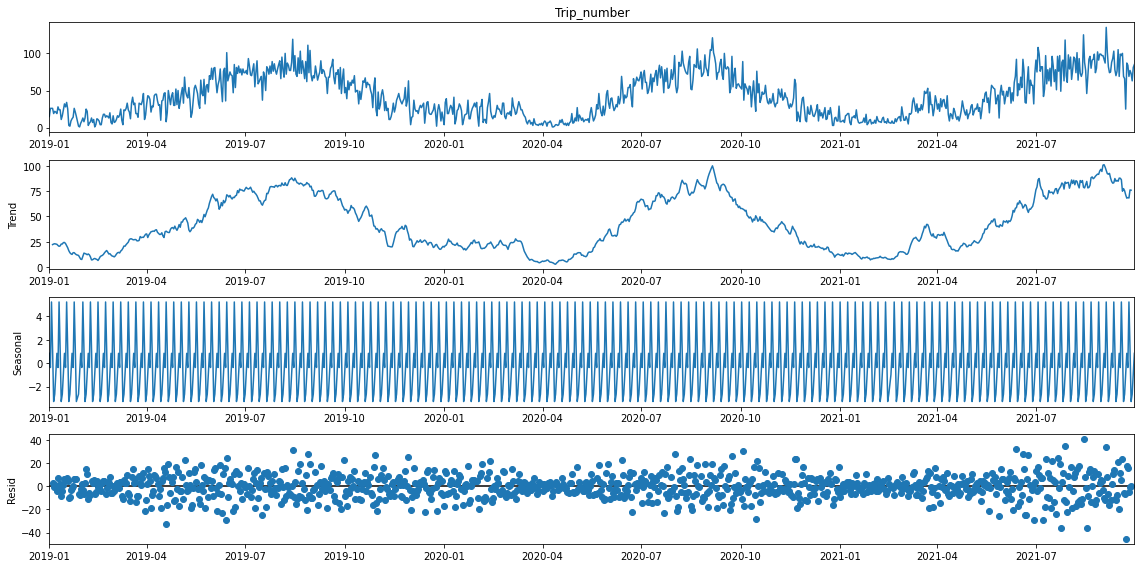

In [7]:
weekly_figure = weekly_components.plot()
plt.show()

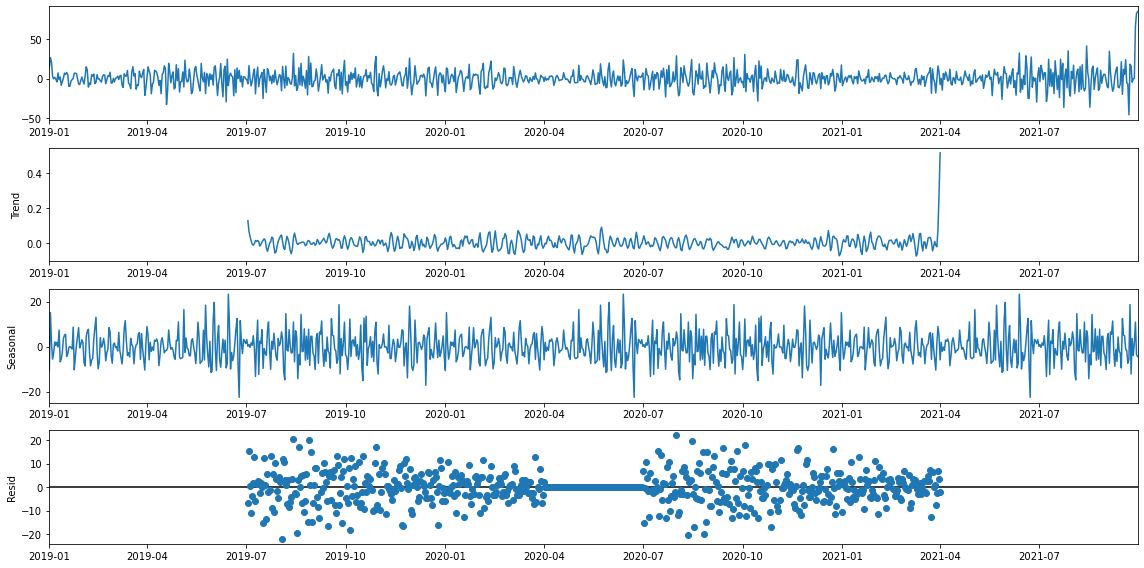

In [8]:
Monthly_plot = Monthly_components.plot()
plt.show()

# TBATS


In [42]:
from tbats import TBATS, BATS

test = data.tail(90)
train = data.head(971-60)

tbats_estimator = TBATS(seasonal_periods=[Weekly_MEASURES,Monthly_MEASURES,], 
                        use_arma_errors=False, use_box_cox=False, n_jobs=1)
tbats_model = tbats_estimator.fit(train.Trip_number)
print(tbats_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 364.]
Seasonal harmonics [3 5]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.124317
Seasonal Parameters (Gamma): [-1.93987589e-09 -2.74074751e-09 -4.85091024e-09 -1.08187459e-08]
AR coefficients []
MA coefficients []
Seed vector [ 44.36039551   0.6136729   -0.60827104   1.47079287   2.39717667
  -1.72644676  -0.25392297 -23.52530933  -0.21605273   0.17501223
   0.9325248    0.24326235 -21.66776973   7.51868773  -0.62968442
  -3.1597342    1.91713422]

AIC 10658.186633


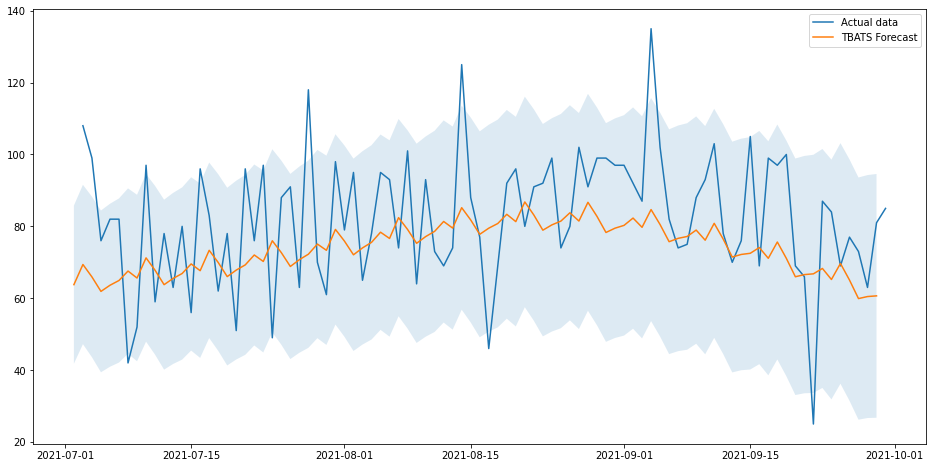

In [46]:
# Forecast 1 month
tbats_forecast_array, confidence_info = tbats_model.forecast(steps=90, confidence_level=0.95)
tbats_forecast_index = pd.date_range(train.index[-1], periods = 91, freq='D')[1:]
tbats_forecast_series = pd.Series(tbats_forecast_array, index=tbats_forecast_index)

plt.plot(test.Trip_number, label = 'Actual data')
plt.plot(tbats_forecast_series, label='TBATS Forecast')
plt.fill_between(tbats_forecast_series.index, confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.15)
plt.legend()
plt.show()

In [50]:
import sklearn.metrics as metrics

In [51]:
metrics.mean_absolute_error(test.Trip_number, tbats_forecast_series)

14.818187272549244

In [52]:
from tbats import TBATS, BATS

tbats_estimator = TBATS(seasonal_periods=[Weekly_MEASURES,Monthly_MEASURES,], 
                        use_arma_errors=False, use_box_cox=False, n_jobs=1)
tbats_model = tbats_estimator.fit(data.Trip_number)
print(tbats_model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 364.]
Seasonal harmonics [3 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.154041
Seasonal Parameters (Gamma): [-2.38146121e-08 -1.03265227e-09  6.55101519e-09 -5.61599806e-09]
AR coefficients []
MA coefficients []
Seed vector [ 45.85672004   0.38490024  -0.69123811   1.14454577   2.88470029
  -1.81045694  -0.44936377 -22.4307863  -23.59472132]

AIC 11943.120482


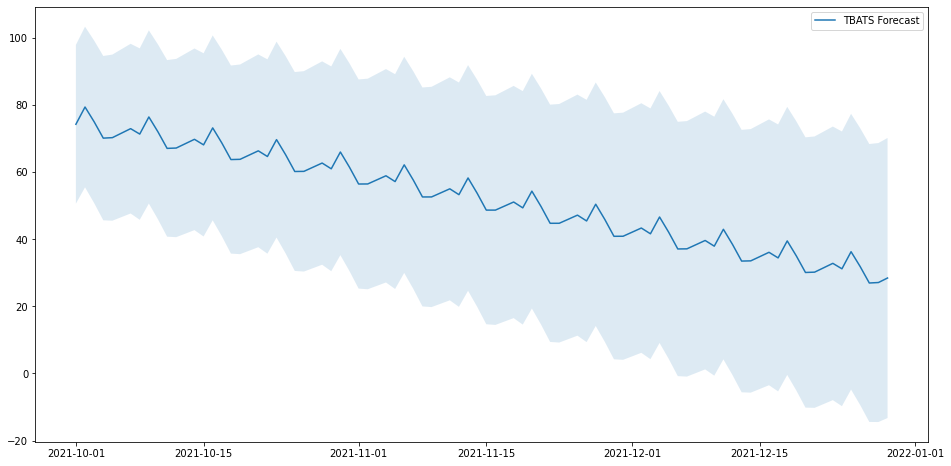

In [56]:
# Forecast one quarter
tbats_forecast_array, confidence_info = tbats_model.forecast(steps=90, confidence_level=0.95)
tbats_forecast_index = pd.date_range(data.index[-1], periods = 1 + 90, freq='D')[1:]
tbats_forecast_series = pd.Series(tbats_forecast_array, index=tbats_forecast_index)

#plt.plot(data.Trip_number, label='Initial Data')
plt.plot(tbats_forecast_series, label='TBATS Forecast')
plt.fill_between(tbats_forecast_series.index, confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.15)
plt.legend()
plt.show()

In [55]:
tbats_forecast_series.to_csv("b.csv")

# ARIMA

In [21]:
import pmdarima as pm

ts=data.Trip_number
model_arima = pm.auto_arima(data.Trip_number, seasonal=True, error_action='ignore', suppress_warnings=True)
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1002
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3953.068
Date:                Tue, 12 Oct 2021   AIC                           7912.137
Time:                        08:14:57   BIC                           7926.863
Sample:                             0   HQIC                          7917.733
                               - 1002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7291      0.026    -27.541      0.000      -0.781      -0.677
ma.L2         -0.0777      0.027     -2.903      0.004      -0.130      -0.025
sigma2       157.4914      5.705     27.608      0.000     146.310     168.672
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.20
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.03
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

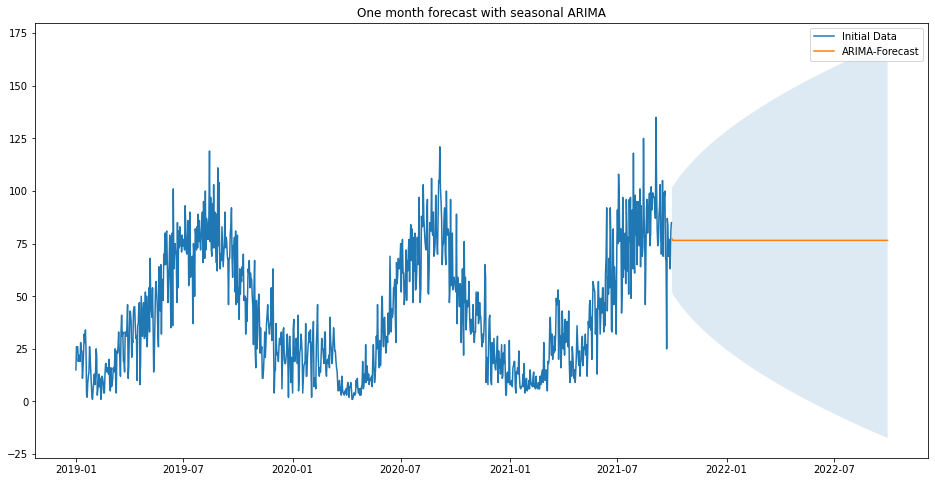

In [22]:
def plot_arima_forecast(model, data, 
                        exogenous_feats=None, n_periods=Monthly_MEASURES, 
                        title="Forecast with ARIMA", forecast_shift=0, call_show=True):
    fcast, confint = model.predict(n_periods, return_conf_int=True, exogenous=exogenous_feats)
    fc_index = pd.date_range(data.index[-1], periods = n_periods+ 1, freq='D')[1:]

    fitted_series = pd.Series(fcast + forecast_shift, index=fc_index)
    lower_series = pd.Series(confint[:, 0] + forecast_shift, index=fc_index)
    upper_series = pd.Series(confint[:, 1] + forecast_shift, index=fc_index)

    plt.plot(data.Trip_number, label="Initial Data")
    plt.plot(fitted_series, label="ARIMA-Forecast")
    plt.fill_between(fc_index, lower_series, upper_series, alpha=.15)
    plt.title(title)
    
    if call_show:
        plt.legend()
        plt.show()

plot_arima_forecast(model_arima, data, title="One month forecast with seasonal ARIMA")

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1002 entries, 2019-01-01 to 2021-09-30
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   weekday      1002 non-null   object
 1   Month        1002 non-null   object
 2   Trip_number  1002 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 31.3+ KB


In [29]:
first_row_weekday, last_row_weekday = data.weekday[0], data.weekday[-1]

exogenous_train    = np.zeros(shape=(data.shape[0], 7), dtype=np.float64)
exogenous_forecast = np.zeros(shape=(Monthly_MEASURES * 2, 7), dtype=np.float64)

for row_idx, weekday in enumerate(data.weekday.values):
    exogenous_train[row_idx][weekday - 1] = 1
    
previous_weekday = last_row_weekday - 1
for day in range(14):
    current_weekday = (previous_weekday + 1) % 52
    for measurement in range(Monthly_MEASURES):
        exogenous_forecast[day * Monthly_MEASURES + measurement, current_weekday] = 1
    previous_weekday = current_weekday
    
exogenous_train    = exogenous_train[:, :51]
exogenous_forecast = exogenous_forecast[:, :51]

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [30]:
# ARIMA on residuals

shift_component = weekly_trend + weekly_seasonal + Monthly_trend + Monthly_seasonal
source_adjusted_series = data.Trip_number - shift_component

row_number = data.shape[0] + Monthly_MEASURES 
feat_trend_measurements = np.arange(row_number)[:row_number].reshape((-1, 1))
feat_trend_weekly = np.repeat(np.arange(row_number / Weekly_MEASURES), Weekly_MEASURES)[:row_number].reshape((-1, 1))
feat_trend_Monthly = np.repeat(np.arange(row_number / Monthly_MEASURES), Monthly_MEASURES)[:row_number].reshape((-1, 1))

Monthly_dummies = np.concatenate([exogenous_train, exogenous_forecast], axis=0)
Week_period_dummies = np.zeros(shape=(row_number, Weekly_MEASURES), dtype=np.float64)
for idx in range(row_number):
    Week_period_dummies[idx][idx % Weekly_MEASURES] = 1
Week_period_dummies = Week_period_dummies[:,:-1]

X_regression = np.concatenate([feat_trend_measurements, feat_trend_weekly, feat_trend_Monthly, Monthly_dummies, Week_period_dummies], axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1366 and the array at index 3 has size 1730

In [ ]:
shift_component = daily_trend + daily_seasonal + weekly_trend + weekly_seasonal
source_adjusted_series = data.electricity_demand - shift_component

row_number = data.shape[0] + WEEKLY_MEASURES * 2
feat_trend_measurements = np.arange(row_number)[:row_number].reshape((-1, 1))
feat_trend_daily = np.repeat(np.arange(row_number / DAILY_MEASURES), DAILY_MEASURES)[:row_number].reshape((-1, 1))
feat_trend_weekly = np.repeat(np.arange(row_number / WEEKLY_MEASURES), WEEKLY_MEASURES)[:row_number].reshape((-1, 1))

weekday_dummies = np.concatenate([exogenous_train, exogenous_forecast], axis=0)
day_period_dummies = np.zeros(shape=(row_number, DAILY_MEASURES), dtype=np.float64)
for idx in range(row_number):
    day_period_dummies[idx][idx % DAILY_MEASURES] = 1
day_period_dummies = day_period_dummies[:,:-1]

X_regression = np.concatenate([feat_trend_measurements, feat_trend_daily, feat_trend_weekly, weekday_dummies, day_period_dummies], axis=1)

In [ ]:
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error

X_train = X_regression[:data.shape[0]]
X_forecast = X_regression[data.shape[0]:]

y_train = np.array(data.Trip_number.values)
regressor = RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 100.0), fit_intercept=True, cv=5)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)
print("MAE = ", mean_absolute_error(y_train, y_pred))

y_forecast = regressor.predict(X_forecast)

In [ ]:
adjusted_series = data.Trip_number - y_pred
adjusted_arima = pm.auto_arima(adjusted_series, seasonal=False,
                               error_action='ignore', suppress_warnings=True)
adjusted_arima.summary()

In [ ]:
plot_arima_forecast(adjusted_arima, data, title="Adjusted ARIMA forecast for 1 year", forecast_shift=y_forecast, call_show=False)
plt.plot(tbats_forecast_series, label='TBATS Forecast')
plt.legend()
plt.show()


# Cross Validation


In [ ]:
import copy


from pmdarima.model_selection import cross_val_score
from pmdarima.model_selection import SlidingWindowForecastCV

data_length = data.shape[0]
sliding_window = SlidingWindowForecastCV(h=Weekly_MEASURES, step=Weekly_MEASURES, window_size=data_length - Weekly_MEASURES - Monthly_MEASURES)


In [ ]:
class WrapperTBATS():
    
    def __init__(self, fitted=None):
        self.Weekly_MEASURES = 7
        self.Monthly_MEASURES = Weekly_MEASURES * 52
        self.fitted = fitted
        
    def fit(self, data, *args, **kwargs):
        tbats = TBATS(
            seasonal_periods=[self.Weekly_MEASURES, self.Monthly_MEASURES], 
            use_arma_errors=False, use_box_cox=False, n_jobs=1)
        self.fitted = tbats.fit(data)
        return copy.deepcopy(self)
    
    # This method implements Scikit-Learn compatible prediction.
    def predict(self, n_periods, *args, **kwargs):
        return self.fitted.forecast(n_periods)
    
    # This method is required to make the class compatible with Scikit-Learn.
    # Essentially, it returns dictionary mapping parameter names to their values.
    def get_params(self, deep=True):
        return {"fitted" : copy.deepcopy(self.fitted)}
    

In [ ]:
cv_tbats_est = WrapperTBATS()

tbats_cv_scores = cross_val_score(
    cv_tbats_est, data.Trip_number, cv=copy.deepcopy(sliding_window), scoring='smape', verbose=2)

print("Average TBATS error: ", np.average(tbats_cv_scores))
print("TBATS errors std: ", np.std(tbats_cv_scores))

In [ ]:
# Cross validation for ARIMA on residual

import math

class ResidualARIMA():
    
    def __init__(self, prediction_limit=None, y_forecast=None, arima_model=None):
        self.Weekly_MEASURES = 7
        self.Monthly_MEASURES = Weekly_MEASURES * 52
        self.prediction_limit = prediction_limit
        if self.prediction_limit is None:
            self.prediction_limit = self.Monthly_MEASURES*1
        self.y_forecast = y_forecast
        self.arima_model = arima_model
    
    # This method repeats all procedures implemented above for ARIMA on linear model residuals.
    def fit(self, fit_data, *args, **kwargs):
        
        # Seasonal Decompositions.
        daily_components = sm.api.tsa.seasonal_decompose(fit_data, period=self.Weekly_MEASURES)
        daily_trend = np.array(daily_components.trend)
        daily_trend[np.isnan(daily_trend)] = 0
        daily_seasonal = daily_components.seasonal

        no_daily_series = fit_data - weekly_seasonal - weekly_trend
        weekly_components = sm.api.tsa.seasonal_decompose(no_daily_series, period=self.WEEKLY_MEASURES)

        weekly_trend = np.array(weekly_components.trend)
        weekly_trend[np.isnan(weekly_trend)] = 0
        weekly_seasonal = weekly_components.seasonal
        
        shift_component = daily_trend + daily_seasonal + weekly_trend + weekly_seasonal
        
        # Preparing the features.
        source_adjusted_series = fit_data - shift_component

        row_number = fit_data.shape[0] + self.prediction_limit
        
        feat_trend_measurements = np.arange(row_number)[:row_number].reshape((-1, 1))
        feat_trend_daily = np.repeat(np.arange(row_number / DAILY_MEASURES), DAILY_MEASURES)[:row_number].reshape((-1, 1))
        feat_trend_weekly = np.repeat(np.arange(row_number / WEEKLY_MEASURES), WEEKLY_MEASURES)[:row_number].reshape((-1, 1))

        weekday_dummies    = np.zeros(shape=(row_number, 7), dtype=np.float64)
        for row_idx in range(row_number):
            day_idx = int(math.floor(row_idx / DAILY_MEASURES))
            weekday_dummies[row_idx][day_idx % 7] = 1
        weekday_dummies = weekday_dummies[:, :6]
        
        day_period_dummies = np.zeros(shape=(row_number, DAILY_MEASURES), dtype=np.float64)
        for idx in range(row_number):
            day_period_dummies[idx][idx % DAILY_MEASURES] = 1
        day_period_dummies = day_period_dummies[:,:-1]

        X_regression = np.concatenate([feat_trend_measurements, feat_trend_daily, feat_trend_weekly, weekday_dummies, day_period_dummies], axis=1)
        
        # Fitting the regression.
        X_train = X_regression[:fit_data.shape[0]]
        X_forecast = X_regression[fit_data.shape[0]:]

        y_train = np.array(fit_data)
        regressor = RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 100.0), fit_intercept=True, cv=5)

        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_train)

        y_forecast = regressor.predict(X_forecast)
        self.y_forecast = y_forecast
        
        # Training ARIMA
        adjusted_series = fit_data - y_pred
        adjusted_arima = pm.auto_arima(adjusted_series, seasonal=False,
                               error_action='ignore', suppress_warnings=True)
        self.arima_model = adjusted_arima
        
        return copy.deepcopy(self)
    
    # This method implements Scikit-Learn compatible prediction.
    def predict(self, n_periods, *args, **kwargs):
        if n_periods > self.prediction_limit:
            raise ValueError("Forecast length exceeds the limit parameter set on initialization!")
        fcast, confint = self.arima_model.predict(n_periods, return_conf_int=True)
        arima_forecast = fcast
        return arima_forecast + self.y_forecast[:n_periods]
    
    # This method is required to make the class compatible with Scikit-Learn.
    # Essentially, it returns dictionary mapping parameter names to their values.
    def get_params(self, deep=True):
        return {
            "prediction_limit" : copy.deepcopy(self.prediction_limit),
            "y_forecast" : copy.deepcopy(self.y_forecast),
            "arima_model" : copy.deepcopy(self.arima_model)
        }
